In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Wed Nov 19 12:52:22 PST 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# V&V List from Docs

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

### Note: This notebook currently only shows results for the baseline scenario.

# Load Data

Results: 

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/china/2025_11_17_08_57_44/results/

Artifact:

/ihme/homes/abie/projects/2025/vivarium_csu_alzheimers/china.hdf

In [2]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
locations = [
            # 'united_states_of_america',
            #  'brazil',
             'china',
            #  'germany',
            #  'israel',
            #  'japan',
            #  'spain',
            #  'sweden',
            #  'taiwan_(province_of_china)',
            #  'united_kingdom',
            ]



results_dirs = [
    'results/abie_consistent_model_test/china/2025_11_17_08_57_44/results/',
    # 'results/model5.0/model_spec/2025_09_25_09_02_38/results/',
]

# artifact_subdirs = ['artifacts/model8.3/' + x + '.hdf' for x in locations]
# artifact_dirs = ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_subdir
#                  for artifact_subdir in artifact_subdirs]
artifact_dirs = ['/ihme/homes/abie/projects/2025/vivarium_csu_alzheimers/china.hdf']
artifact_dirs

['/ihme/homes/abie/projects/2025/vivarium_csu_alzheimers/china.hdf']

In [4]:
apath = artifact_dirs[0]
!ls $apath

/ihme/homes/abie/projects/2025/vivarium_csu_alzheimers/china.hdf


In [5]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['counts_newly_eligible_for_bbbm_testing.parquet',
 'deaths.parquet',
 'counts_new_simulants.parquet',
 'ylls.parquet',
 'person_time_eligible_for_bbbm_testing.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'transition_count_treatment.parquet',
 'ylds.parquet',
 'counts_bbbm_tests.parquet',
 'person_time_treatment.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet',
 'person_time_ever_eligible_for_bbbm_testing.parquet',
 'counts_baseline_tests_among_eligible.parquet']

In [6]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


## Verify that all simulants in the model have AD 

In [7]:
# filters = [('artifact_path', '==', artifact_dirs[0])]
filters=None
test = pd.read_parquet(results_dirs[0] + 'deaths' + '.parquet', filters=filters)
# test['location'] = locations[0]
test#.artifact_path.unique()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,scenario,input_draw,random_seed,value
0,deaths,cause,alzheimers_mild_dementia_state,alzheimers_mild_dementia_state,25_to_29,2022,Female,baseline,169,2787,0.0
1,deaths,cause,alzheimers_mild_dementia_state,alzheimers_mild_dementia_state,25_to_29,2022,Male,baseline,169,2787,0.0
2,deaths,cause,alzheimers_mild_dementia_state,alzheimers_mild_dementia_state,25_to_29,2023,Female,baseline,169,2787,0.0
3,deaths,cause,alzheimers_mild_dementia_state,alzheimers_mild_dementia_state,25_to_29,2023,Male,baseline,169,2787,0.0
4,deaths,cause,alzheimers_mild_dementia_state,alzheimers_mild_dementia_state,25_to_29,2024,Female,baseline,169,2787,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8531995,deaths,cause,other_causes,other_causes,95_plus,2098,Male,bbbm_testing_and_treatment,457,7438,86.0
8531996,deaths,cause,other_causes,other_causes,95_plus,2099,Female,bbbm_testing_and_treatment,457,7438,677.0
8531997,deaths,cause,other_causes,other_causes,95_plus,2099,Male,bbbm_testing_and_treatment,457,7438,78.0
8531998,deaths,cause,other_causes,other_causes,95_plus,2100,Female,bbbm_testing_and_treatment,457,7438,673.0


In [8]:
[[('artifact_path', '==', artifact_dir)]
                 for artifact_dir in artifact_dirs
                 ]

[[('artifact_path',
   '==',
   '/ihme/homes/abie/projects/2025/vivarium_csu_alzheimers/china.hdf')]]

In [9]:
def print_memory_usage(df, label=''):
    """Print the memory usage of a dataframe in megabytes."""
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB', label)

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None

def load_df(measure):
    # data = pd.DataFrame()
    dfs_by_location = []
    data_all = pd.read_parquet(
        results_dirs[0] + measure + '.parquet',
        # # Combine location filters with OR using disjunctive normal form
        # filters=[[('artifact_path', '==', artifact_dir)]
        #          for artifact_dir in artifact_dirs
        #          ],
    )
    print_memory_usage(data_all, 'for parquet file loaded into memory')
    convert_to_categorical(data_all, inplace=True)
    print_memory_usage(data_all, 'after converting to categorical')
    # Loop through unique locations (artifact paths), and aggregate
    # random seeds for each one, then concatenate
    for location, artifact in zip(locations, artifact_dirs):
        temp = data_all#[data_all.artifact_path == artifact]

        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols, observed=True)['value'].sum().reset_index()
        
        temp['location'] = location
        # temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['event_year'] = temp['event_year'].astype(int)
        # data = pd.concat([data, temp], ignore_index=True)
        dfs_by_location.append(temp)
    data = pd.concat(dfs_by_location, ignore_index=True)
    print_memory_usage(data, 'after aggregating seeds')
    convert_to_categorical(data, exclude_cols=['event_year'], inplace=True)
    print_memory_usage(data, 'after converting aggregated data to categoricals')
    return data

In [10]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time
# person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

31323.115442 MB for parquet file loaded into memory
1823.731416 MB after converting to categorical
83.511475 MB after aggregating seeds
24.960795 MB after converting aggregated data to categoricals


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,baseline,169,0.000000,china
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,baseline,323,0.000000,china
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,baseline,457,0.000000,china
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,bbbm_testing,169,0.000000,china
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,bbbm_testing,323,0.000000,china
...,...,...,...,...,...,...,...,...,...,...,...,...
959845,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing,323,176.394251,china
959846,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing,457,491.811088,china
959847,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing_and_treatment,169,218.250513,china
959848,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing_and_treatment,323,48.832307,china


In [11]:
person_time.location.unique()

['china']
Categories (1, object): ['china']

In [12]:
person_time.memory_usage(deep=True)

Index              132
measure         960026
entity_type     960020
entity          960053
sub_entity      960483
age_group       961380
event_year     7678800
sex             960082
treatment       960842
scenario        960175
input_draw      959982
value          7678800
location        960020
dtype: int64

In [13]:
person_time.dtypes

measure        category
entity_type    category
entity         category
sub_entity     category
age_group      category
event_year        int64
sex            category
treatment      category
scenario       category
input_draw     category
value           float64
location       category
dtype: object

In [14]:
# This is insane -- 45 GB!
print_memory_usage(person_time)

24.960795 MB 


In [15]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [16]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        2.082224e+09
alzheimers_mild_cognitive_impairment_state    9.304413e+08
alzheimers_mild_dementia_state                5.933629e+08
alzheimers_moderate_dementia_state            4.883846e+08
alzheimers_severe_dementia_state              3.328736e+08
Name: value, dtype: float64

In [17]:
person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity                     alzheimers_blood_based_biomarker_state  \
location event_year age_group                                           
china    2022       25_to_29                             0.000000e+00   
                    30_to_34                             2.373250e+04   
                    35_to_39                             1.750937e+04   
                    40_to_44                             6.509396e+04   
                    45_to_49                             2.868798e+04   
...                                                               ...   
         2100       75_to_79                             6.256480e+06   
                    80_to_84                             7.103111e+06   
                    85_to_89                             5.023621e+06   
                    90_to_94                             2.229235e+06   
                    95_plus                              6.389239e+05   

sub_entity                     alzheimers_mild_cognitive_impairment_state  \
location event_year age_group                                               
china    2022       25_to_29                                 0.000000e+00   
                    30_to_34                                 1.614456e+02   
                    35_to_39                                 8.969199e+01   
                    40_to_44                                 6.456030e+04   
                    45_to_49                                 2.048117e+04   
...                                                                   ...   
         2100       75_to_79                                 2.304395e+06   
                    80_to_84                                 3.164653e+06   
                    85_to_89                                 2.849327e+06   
                    90_to_94                                 1.585283e+06   
                    95_plus                                  6.553171e+05   

sub_entity                     alzheimers_mild_dementia_state  \
location event_year age_group                                   
china    2022       25_to_29                     0.000000e+00   
                    30_to_34                     8.969199e+00   
                    35_to_39                     2.989733e+00   
                    40_to_44                     5.924156e+03   
                    45_to_49                     2.280419e+04   
...                                                       ...   
         2100       75_to_79                     1.426561e+06   
                    80_to_84                     1.910167e+06   
                    85_to_89                     1.676616e+06   
                    90_to_94                     9.339717e+05   
                    95_plus                      4.117655e+05   

sub_entity                     alzheimers_moderate_dementia_state  \
location event_year age_group                                       
china    2022       25_to_29                         0.000000e+00   
                    30_to_34                         0.000000e+00   
                    35_to_39                         0.000000e+00   
                    40_to_44                         1.823737e+02   
                    45_to_49                         7.891400e+03   
...                                                           ...   
         2100       75_to_79                         9.304747e+05   
                    80_to_84                         1.513238e+06   
                    85_to_89                         1.725668e+06   
                    90_to_94                         1.188499e+06   
                    95_plus                          6.573103e+05   

sub_entity                     alzheimers_severe_dementia_state  
location event_year age_group                                    
china    2022       25_to_29                       0.000000e+00  
                    30_to_34                       0.000000e+00  
                    35_to_39            

In [18]:
#assert np.all(person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [19]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

25442.434507 MB for parquet file loaded into memory
1458.988486 MB after converting to categorical
66.810155 MB after aggregating seeds
19.969645 MB after converting aggregated data to categoricals


0.0

In [20]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [21]:
# assert np.all(trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [22]:
out_counts = trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
#out_counts

In [23]:
out_counts

alzheimers_blood_based_biomarker_state  \
location event_year age_group                                           
china    2022       25_to_29                                      0.0   
                    30_to_34                                   2388.0   
                    35_to_39                                   1842.0   
                    40_to_44                                   8832.0   
                    45_to_49                                   3891.0   
...                                                               ...   
         2100       75_to_79                                 875077.0   
                    80_to_84                                1030454.0   
                    85_to_89                                 766670.0   
                    90_to_94                                 346096.0   
                    95_plus                                  104987.0   

                               alzheimers_mild_cognitive_impairment_state  \
location event_year age_group                                               
china    2022       25_to_29                                          0.0   
                    30_to_34                                         27.0   
                    35_to_39                                         15.0   
                    40_to_44                                      16698.0   
                    45_to_49                                       5412.0   
...                                                                   ...   
         2100       75_to_79                                     592384.0   
                    80_to_84                                     802335.0   
                    85_to_89                                     707242.0   
                    90_to_94                                     381759.0   
                    95_plus                                      153336.0   

                               alzheimers_mild_dementia_state  \
location event_year age_group                                   
china    2022       25_to_29                              0.0   
                    30_to_34                              3.0   
                    35_to_39                              3.0   
                    40_to_44                            918.0   
                    45_to_49                           3624.0   
...                                                       ...   
         2100       75_to_79                         398935.0   
                    80_to_84                         622275.0   
                    85_to_89                         645491.0   
                    90_to_94                         378916.0   
                    95_plus                          170410.0   

                               alzheimers_moderate_dementia_state  
location event_year age_group                                      
china    2022       25_to_29                                  0.0  
                    30_to_34                                  0.0  
                    35_to_39                                  0.0  
                    40_to_44                                 54.0  
                    45_to_49                               1464.0  
...                                                           ...  
         2100       75_to_79                             192295.0  
                    80_to_84                             317040.0  
                    85_to_89                             368889.0  
                    90_to_94                             244693.0  
                    95_plus                              129446.0  

[1185 rows x 4 columns]

In [24]:
out_rates = out_counts / person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
#out_rates['alzheimers_blood_based_biomarker_state'].unstack()

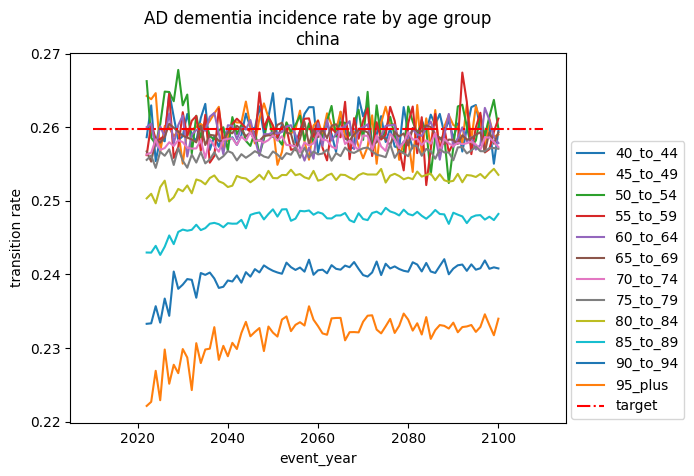

In [25]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
for location in trans.location.unique():
    # .iloc[:,3:] filters out the first 3 age groups, which have 0 or
    # very few people
    t.loc[location].iloc[:,3:].plot(ylabel='transition rate')
    plt.title(f"AD dementia incidence rate by age group\n{location}")
    plt.hlines(1/3.85, 2010, 2110, 'red', ls='-.', label='target')
    plt.legend(loc=(1.01, .01))

In [26]:
1 / 3.85

0.2597402597402597

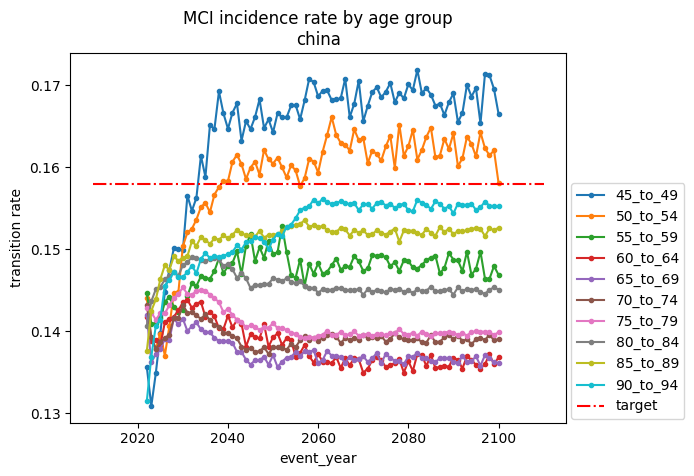

In [27]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:,4:14].plot(marker='.', ylabel='transition rate')
    plt.title(location)
    plt.title(f"MCI incidence rate by age group\n{location}")
    # target is 1 / mean of Weibull distribution
    plt.hlines(0.15791673988674756, 2010, 2110, 'red', ls='-.', label='target')
    plt.legend(loc=(1.01, .01))

In [28]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
#mci_duration_est

# Load counts of new simulants

In [29]:
new_sims = load_df('counts_new_simulants')
new_sims.head()

211.886817 MB for parquet file loaded into memory
29.876242 MB after converting to categorical
1.751411 MB after aggregating seeds
0.450451 MB after converting aggregated data to categoricals


,age_group,event_year,sex,scenario,input_draw,value,location
0,25_to_29,2022,Female,baseline,169,0.0,china
1,25_to_29,2022,Female,baseline,323,0.0,china
2,25_to_29,2022,Female,baseline,457,0.0,china
3,25_to_29,2022,Female,bbbm_testing,169,0.0,china
4,25_to_29,2022,Female,bbbm_testing,323,0.0,china


In [30]:
new_sims_by_year_and_age = new_sims.groupby(['location', 'event_year', 'age_group', ]).value.sum()

bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims_by_year_and_age
)
#bbbm_duration_est

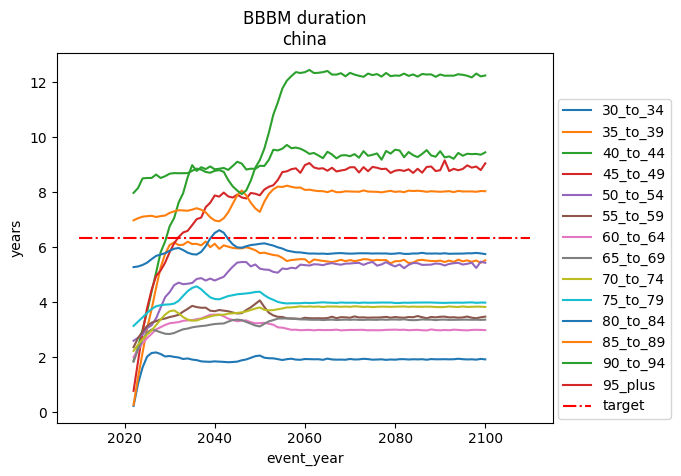

In [31]:
t = bbbm_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot(ylabel='years')
    # Target is mean of Weibull distribution
    plt.hlines(6.332450889735727, 2010, 2110, 'red', ls='-.', label='target')
    plt.title(f'BBBM duration\n{location}')
    plt.legend(loc=(1.01, .01))

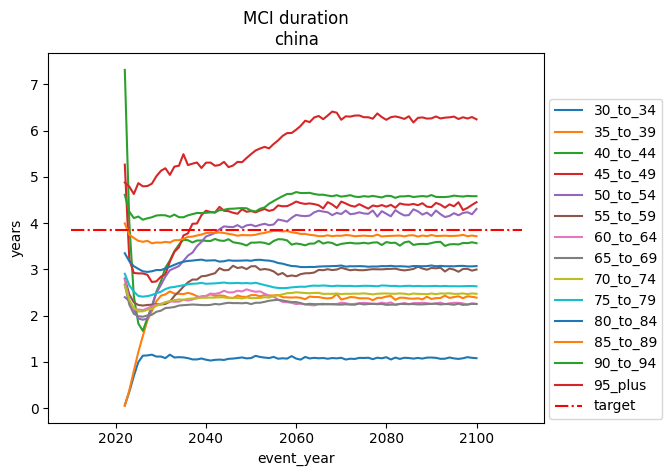

In [32]:
t = mci_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot(ylabel='years')
    plt.hlines(3.85, 2010, 2110, 'red', ls='-.', label='target')
    plt.title(f'MCI duration\n{location}')
    plt.legend(loc=(1.01, .01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [33]:
%%time

cols = ['input_draw','event_year','location','age_group','sex']

# Load deaths dataframe
deaths = load_df('deaths')

def calculate_ocmr(person_time, deaths):
    # person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time.groupby(cols).sum(numeric_only=True)

    # deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr(person_time, deaths)

1410.634003 MB for parquet file loaded into memory
153.591599 MB after converting to categorical
7.341228 MB after aggregating seeds
2.136878 MB after converting aggregated data to categoricals
CPU times: user 18 s, sys: 1.57 s, total: 19.6 s
Wall time: 17.1 s


In [34]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)]
    art_ocmr = pd.concat([art_ocmr, data4])
#art_ocmr

In [35]:
art_data = art_ocmr
# location = 'United_States_Of_America'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [36]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.event_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


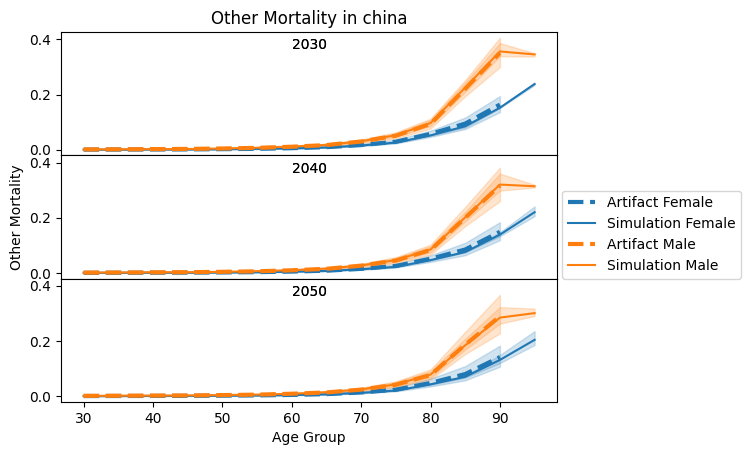

In [37]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [38]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.event_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

In [39]:
person_time

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,baseline,169,0.000000,china
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,baseline,323,0.000000,china
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,baseline,457,0.000000,china
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,bbbm_testing,169,0.000000,china
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,bbbm_testing,323,0.000000,china
...,...,...,...,...,...,...,...,...,...,...,...,...
959845,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing,323,176.394251,china
959846,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing,457,491.811088,china
959847,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing_and_treatment,169,218.250513,china
959848,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing_and_treatment,323,48.832307,china


In [40]:
deaths

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,scenario,input_draw,value,location
0,deaths,cause,alzheimers_mild_dementia_state,alzheimers_mild_dementia_state,25_to_29,2022,Female,baseline,169,0.0,china
1,deaths,cause,alzheimers_mild_dementia_state,alzheimers_mild_dementia_state,25_to_29,2022,Female,baseline,323,0.0,china
2,deaths,cause,alzheimers_mild_dementia_state,alzheimers_mild_dementia_state,25_to_29,2022,Female,baseline,457,0.0,china
3,deaths,cause,alzheimers_mild_dementia_state,alzheimers_mild_dementia_state,25_to_29,2022,Female,bbbm_testing,169,0.0,china
4,deaths,cause,alzheimers_mild_dementia_state,alzheimers_mild_dementia_state,25_to_29,2022,Female,bbbm_testing,323,0.0,china
...,...,...,...,...,...,...,...,...,...,...,...
85315,deaths,cause,other_causes,other_causes,95_plus,2100,Male,bbbm_testing,323,3026.0,china
85316,deaths,cause,other_causes,other_causes,95_plus,2100,Male,bbbm_testing,457,7056.0,china
85317,deaths,cause,other_causes,other_causes,95_plus,2100,Male,bbbm_testing_and_treatment,169,7605.0,china
85318,deaths,cause,other_causes,other_causes,95_plus,2100,Male,bbbm_testing_and_treatment,323,3075.0,china


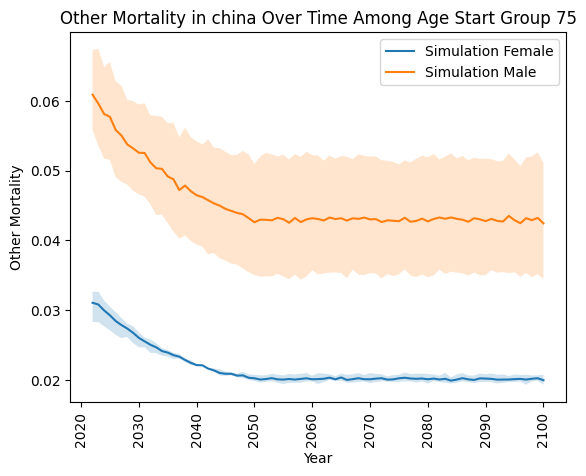

<Figure size 640x480 with 0 Axes>

In [41]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR in severe dementia against GBD

In [42]:
cols = ['input_draw','event_year','location','age_group','sex', 'scenario']
scenario = 'baseline'
severity = 'severe'

def calculate_emr(person_time, deaths):
    # person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time.loc[
        (person_time.sub_entity == f'alzheimers_{severity}_dementia_state')
        & (person_time.scenario == scenario)
    ].groupby(cols, observed=True).sum(numeric_only=True)
    assert len(infected) > 0

    # deaths0 = load_df('deaths')
    deaths = deaths.loc[
        (deaths.sub_entity == f'alzheimers_{severity}_dementia_state')
        & (deaths.scenario == scenario)
    ].groupby(cols, observed=True).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr(person_time, deaths)

In [43]:
sim_emr

,event_year,location,age_group,sex,scenario,age_start,count,mean,std,min,2.5%,50%,97.5%,max
0,2022,china,30_to_34,Female,baseline,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,china,30_to_34,Male,baseline,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,china,35_to_39,Female,baseline,35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,china,35_to_39,Male,baseline,35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,china,40_to_44,Female,baseline,40.0,3.0,0.557463,0.510924,0.000000,0.033448,0.668956,0.986710,1.003434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,2100,china,85_to_89,Male,baseline,85.0,3.0,0.255627,0.017050,0.241162,0.241668,0.251292,0.273269,0.274426
2208,2100,china,90_to_94,Female,baseline,90.0,3.0,0.296140,0.020258,0.280075,0.280544,0.289448,0.317424,0.318897
2209,2100,china,90_to_94,Male,baseline,90.0,3.0,0.293684,0.055857,0.231703,0.235579,0.309223,0.338582,0.340127
2210,2100,china,95_plus,Female,baseline,95.0,3.0,0.331401,0.025058,0.316186,0.316262,0.317695,0.358192,0.360323


In [44]:
def load_artifact_cause_data(measure, year_start=2025):
    # out = pd.DataFrame()
    artifact_data = []
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = [f'year_start=={year_start}'])
        data = art.load(f'cause.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)]
        # out = pd.concat([out, data])
        artifact_data.append(data)
    out = pd.concat(artifact_data)
    return out

In [45]:
print(art)

Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		ad_dementia_prevalence
		mixed_dementia_prevalence
		ad_dementia_population_incidence_rate
		mixed_dementia_population_incidence_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		excess_mortality_rate
		restrictions
		cause_specific_mortality_rate
	dementia
		excess_mortality_rate
	alzheimers_consistent
		alzheimers_prevalence
		population_incidence_mild_dementia
		susceptible_to_bbbm_ad_transition_rate
		mild_to_moderate_dementia_transition_rate
		moderate_to_severe_dementia_transition_rate
		excess_mortality_rate_mild
		excess_mortality_rate_moderate
		excess_mortality_rate_severe
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mild_dementia_conditional_prevalence
		moderate_dementia_conditional_p

In [46]:
art_emr = load_artifact_cause_data(f'alzheimers_consistent.excess_mortality_rate_{severity}')
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Male,30,35,2025,2026,0.102450,0.054440,0.164925,11,30 to 34,30_to_34,alzheimers_consistent.excess_mortality_rate_se...,china
1,Female,30,35,2025,2026,0.125981,0.079755,0.157769,11,30 to 34,30_to_34,alzheimers_consistent.excess_mortality_rate_se...,china
2,Male,35,40,2025,2026,0.103415,0.059232,0.160055,12,35 to 39,35_to_39,alzheimers_consistent.excess_mortality_rate_se...,china
3,Female,35,40,2025,2026,0.127265,0.082345,0.155446,12,35 to 39,35_to_39,alzheimers_consistent.excess_mortality_rate_se...,china
4,Male,40,45,2025,2026,0.104843,0.062006,0.164053,13,40 to 44,40_to_44,alzheimers_consistent.excess_mortality_rate_se...,china


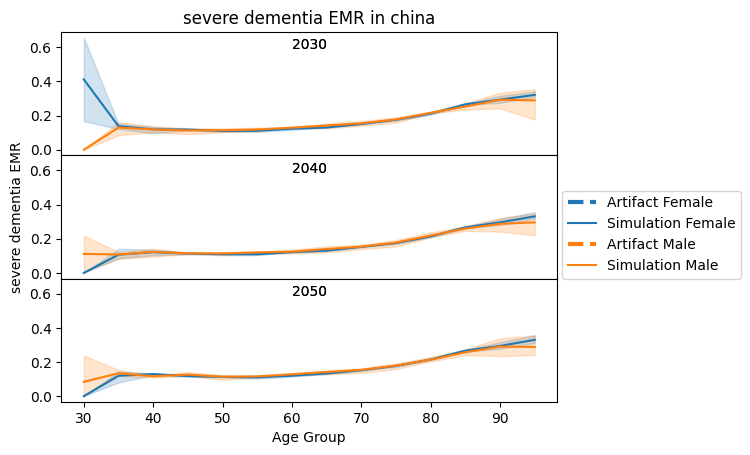

In [47]:
age_group_plot(f'{severity} dementia EMR', sim_emr, art_emr, art_year=2021)

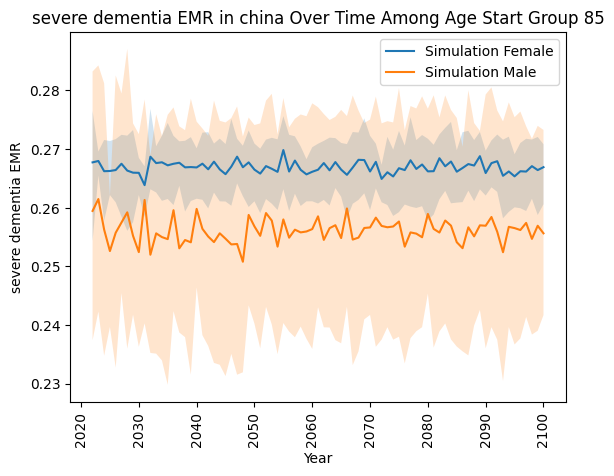

<Figure size 640x480 with 0 Axes>

In [48]:
over_time_plot(f'{severity} dementia EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [49]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers_consistent.population_incidence_mild_dementia'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    # df['location'] = df.location.str.replace(' ', '_').str.lower()
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
art_incidence_data.tail()
    

draw_0  \
sex  age_start age_end location year_start year_end                 
Male 90        95      China    2046       2047      42520.877945   
                                2047       2048      41795.176140   
                                2048       2049      40596.985754   
                                2049       2050      39816.436189   
                                2050       2051      40061.092187   

                                                           draw_1  \
sex  age_start age_end location year_start year_end                 
Male 90        95      China    2046       2047      55573.472758   
                                2047       2048      54971.457554   
                                2048       2049      53807.227974   
                                2049       2050      53253.839359   
                                2050       2051      54129.732067   

                                                           draw_2  \
sex  age_start age_end location year_start year_end                 
Male 90        95      China    2046       2047      73707.313130   
                                2047       2048      72794.220323   
                                2048       2049      70727.951217   
                                2049       2050      69296.675532   
                                2050       2051      69768.636027   

                                                           draw_3  \
sex  age_start age_end location year_start year_end                 
Male 90        95      China    2046       2047      63673.595392   
                                2047       2048      63399.538591   
                                2048       2049      62241.385384   
                                2049       2050      61645.601110   
                                2050       2051      62678.713455   

                                                           draw_4  \
sex  age_start age_end location year_start year_end                 
Male 90        95      China    2046       2047      39650.683378   
                                2047       2048      38500.674723   
                                2048       2049      36962.147557   
                                2049       2050      35897.928998   
                                2050       2051      35809.167239   

                                                           draw_5  \
sex  age_start age_end location year_start year_end                 
Male 90        95      China    2046       2047      61279.959593   
                                2047       2048      60913.541306   
                                2048       2049      59634.976988   
                                2049       2050      58813.846487   
                                2050       2051      59532.713006   

                                                           draw_6  \
sex  age_start age_end location year_start year_end                 
Male 90        95      China    2046       2047      54923.084758   
                                2047       2048      53987.972696   
                                2048       2049      52324.308410   
                                2049       2050      51233.162330   
                                2050       2051      51545.852874   

                                                           draw_7  \
sex  age_start age_end location year_start year_end                 
Male 90        95      China    2046       2047      67851.011542   
                                2047       2048      67870.058462   
                                2048       2049      66858.139109   
                                2049       2050      66322.194586   
                                2050       2051      67420.303393   

                                                           draw_8  \
sex  age_start age_end location year_start year_end                 
Male 90        95      China    2046       2047  

In [50]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.lower()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2025"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean
    
    # NOTE: population 100_000 for V&V (5 seeds), 2_000_000 for final
    # runs (100 seeds)
    ratio = 2_000_000 / prev
    print(ratio)

    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'event_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
#scale

0.11144092159235205


In [51]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
china,168.0,0.022288,2.777211e-18,0.022288,0.022288,0.022288,0.022288,0.022288


In [52]:
# new_sims = load_df('counts_new_simulants')
new_sims.head()

,age_group,event_year,sex,scenario,input_draw,value,location
0,25_to_29,2022,Female,baseline,169,0.0,china
1,25_to_29,2022,Female,baseline,323,0.0,china
2,25_to_29,2022,Female,baseline,457,0.0,china
3,25_to_29,2022,Female,bbbm_testing,169,0.0,china
4,25_to_29,2022,Female,bbbm_testing,323,0.0,china


In [53]:
person_time.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_mild_dementia_state', 'alzheimers_moderate_dementia_state', 'alzheimers_severe_dementia_state']
Categories (5, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_mild_dementia_state', 'alzheimers_moderate_dementia_state', 'alzheimers_severe_dementia_state']

In [54]:
# trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_mild_dementia_state']
new_ad_dementia

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,scenario,input_draw,value,location
191970,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,baseline,169,0.0,china
191971,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,baseline,323,0.0,china
191972,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,baseline,457,0.0,china
191973,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,bbbm_testing,169,0.0,china
191974,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,bbbm_testing,323,0.0,china
...,...,...,...,...,...,...,...,...,...,...,...,...
383935,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,bbbm_testing,323,36.0,china
383936,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,bbbm_testing,457,82.0,china
383937,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,bbbm_testing_and_treatment,169,20.0,china
383938,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,bbbm_testing_and_treatment,323,9.0,china


In [55]:
new_sims_with_scale = new_sims.merge(scale[['location','sex','age_group','ratio','event_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','event_year']])

In [56]:
new_ad_dementia

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,scenario,input_draw,value,location,ratio
0,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,baseline,169,0.0,china,0.111441
1,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,baseline,323,3.0,china,0.111441
2,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,baseline,457,3.0,china,0.111441
3,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,bbbm_testing,169,0.0,china,0.111441
4,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,bbbm_testing,323,3.0,china,0.111441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65767,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,bbbm_testing,323,2.0,china,0.111441
65768,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,bbbm_testing,457,12.0,china,0.111441
65769,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,bbbm_testing_and_treatment,169,9.0,china,0.111441
65770,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,bbbm_testing_and_treatment,323,1.0,china,0.111441


In [57]:
new_sims_with_scale

,age_group,event_year,sex,scenario,input_draw,value,location,ratio
0,30_to_34,2022,Female,baseline,169,3911.0,china,0.111441
1,30_to_34,2022,Female,baseline,323,3594.0,china,0.111441
2,30_to_34,2022,Female,baseline,457,13215.0,china,0.111441
3,30_to_34,2022,Female,bbbm_testing,169,3911.0,china,0.111441
4,30_to_34,2022,Female,bbbm_testing,323,3594.0,china,0.111441
...,...,...,...,...,...,...,...,...
7303,95_plus,2050,Male,bbbm_testing,323,0.0,china,0.111441
7304,95_plus,2050,Male,bbbm_testing,457,0.0,china,0.111441
7305,95_plus,2050,Male,bbbm_testing_and_treatment,169,0.0,china,0.111441
7306,95_plus,2050,Male,bbbm_testing_and_treatment,323,0.0,china,0.111441


In [58]:
cols = ['input_draw','event_year','location','age_group','sex', 'scenario']

new_sims_with_scale['total_incidence'] = new_sims_with_scale['value'] / new_sims_with_scale['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_ad_dementia['ratio']

def summarize(df):
    df = df.groupby(cols, observed=True).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims_with_scale)

In [59]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,event_year,location,age_group,sex,scenario,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2022,china,30_to_34,Female,baseline,3.0,17.946729,15.542323,0.000000,1.346005,26.920093,26.920093,26.920093,11,30 to 34,30.0,35.0
1,2022,china,30_to_34,Female,bbbm_testing,3.0,17.946729,15.542323,0.000000,1.346005,26.920093,26.920093,26.920093,11,30 to 34,30.0,35.0
2,2022,china,30_to_34,Female,bbbm_testing_and_treatment,3.0,17.946729,15.542323,0.000000,1.346005,26.920093,26.920093,26.920093,11,30 to 34,30.0,35.0
3,2022,china,30_to_34,Male,baseline,3.0,8.973364,8.973364,0.000000,0.448668,8.973364,17.498061,17.946729,11,30 to 34,30.0,35.0
4,2022,china,30_to_34,Male,bbbm_testing,3.0,8.973364,8.973364,0.000000,0.448668,8.973364,17.498061,17.946729,11,30 to 34,30.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,2050,china,95_plus,Female,bbbm_testing,3.0,93610.137559,18896.143508,76453.064801,77156.127903,90514.326837,112695.586330,113863.021040,33,95 to 99,95.0,125.0
2432,2050,china,95_plus,Female,bbbm_testing_and_treatment,3.0,94232.290825,19063.228612,76874.812929,77590.438741,91187.329168,113462.360319,114634.730380,33,95 to 99,95.0,125.0
2433,2050,china,95_plus,Male,baseline,3.0,6152.736866,2499.824289,3266.304646,3481.665392,7573.519565,7616.143046,7618.386387,33,95 to 99,95.0,125.0
2434,2050,china,95_plus,Male,bbbm_testing,3.0,6152.736866,2499.824289,3266.304646,3481.665392,7573.519565,7616.143046,7618.386387,33,95 to 99,95.0,125.0


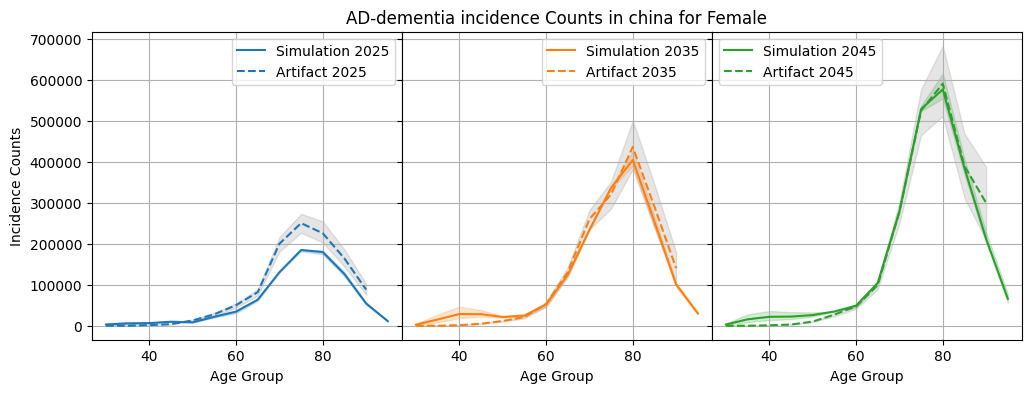

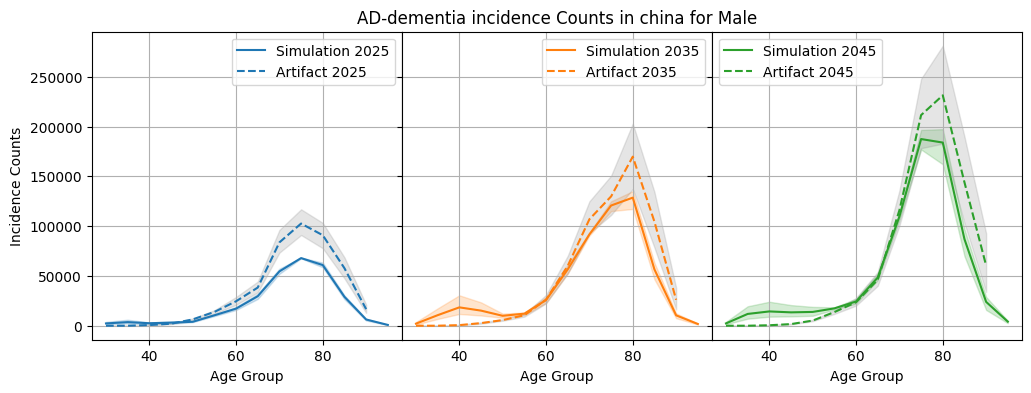

In [80]:
scenario = 'baseline'
for location in new_sims_with_scale.location.unique():
    for sex in new_sims_with_scale.sex.unique():
        fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,4))
        plt.subplots_adjust(wspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query(
                'location == @location and event_year == @year and sex == @sex'
                ' and scenario == @scenario'
                )

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 1:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 0:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend()#(loc=(1.01, 0))


I did some manual checks against GBD compare to make sure these were less than those, with the expectation they are about half. 

In [61]:
plot_data

,event_year,location,age_group,sex,scenario,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
141,2045,china,30_to_34,Male,baseline,3.0,2345.039233,1475.083919,1435.738306,1441.570993,1552.392043,3922.257585,4046.987350,11,30 to 34,30.0,35.0
315,2045,china,35_to_39,Male,baseline,3.0,11838.858783,7199.660448,6972.304149,7045.437069,8434.962548,19525.592295,20109.309650,12,35 to 39,35.0,40.0
489,2045,china,40_to_44,Male,baseline,3.0,14354.391940,9110.392816,9090.018151,9090.466819,9098.991515,24085.407422,24874.166154,13,40 to 44,40.0,45.0
663,2045,china,45_to_49,Male,baseline,3.0,13427.144284,6829.256987,9368.192447,9379.857821,9601.499922,20726.228454,21311.740482,14,45 to 49,45.0,50.0
837,2045,china,50_to_54,Male,baseline,3.0,13857.865776,4868.662853,9870.700855,9998.122629,12419.136348,18940.528935,19283.760124,15,50 to 54,50.0,55.0
1011,2045,china,55_to_59,Male,baseline,3.0,17417.300326,1183.906131,16134.109215,16209.934144,17650.607801,18426.355154,18467.183963,16,55 to 59,55.0,60.0
1185,2045,china,60_to_64,Male,baseline,3.0,24353.711018,2617.901213,22119.343279,22198.757554,23707.628780,27057.834384,27234.160994,17,60 to 64,60.0,65.0
1359,2045,china,65_to_69,Male,baseline,3.0,48417.283253,3697.182225,45665.451499,45730.508391,46966.589339,52337.147940,52619.808919,18,65 to 69,65.0,70.0
1533,2045,china,70_to_74,Male,baseline,3.0,109702.371074,3815.382675,105822.886526,106023.441220,109833.980419,113269.432984,113450.246277,19,70 to 74,70.0,75.0
1707,2045,china,75_to_79,Male,baseline,3.0,187474.520444,10403.819213,176407.371001,177035.057841,188961.107815,196650.383781,197055.082516,20,75 to 79,75.0,80.0


## Verifying Prevalence of AD Dementia

In [ ]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            # This key is the prevalence of all 5 states:
            # 'cause.alzheimers_consistent.alzheimers_prevalence'
            # This key is the prevalence of the 3 dementia states:
            'cause.alzheimers.ad_dementia_prevalence'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data.head()

draw_0  draw_1  draw_2  \
sex    age_start age_end location year_start year_end                           
Female 5.0       10.0    China    2021       2022         0.0     0.0     0.0   
                                  2022       2023         0.0     0.0     0.0   
                                  2023       2024         0.0     0.0     0.0   
                                  2024       2025         0.0     0.0     0.0   
                                  2025       2026         0.0     0.0     0.0   

                                                       draw_3  draw_4  draw_5  \
sex    age_start age_end location year_start year_end                           
Female 5.0       10.0    China    2021       2022         0.0     0.0     0.0   
                                  2022       2023         0.0     0.0     0.0   
                                  2023       2024         0.0     0.0     0.0   
                                  2024       2025         0.0     0.0     0.0   
                                  2025       2026         0.0     0.0     0.0   

                                                       draw_6  draw_7  draw_8  \
sex    age_start age_end location year_start year_end                           
Female 5.0       10.0    China    2021       2022         0.0     0.0     0.0   
                                  2022       2023         0.0     0.0     0.0   
                                  2023       2024         0.0     0.0     0.0   
                                  2024       2025         0.0     0.0     0.0   
                                  2025       2026         0.0     0.0     0.0   

                                                       draw_9  ...  draw_490  \
sex    age_start age_end location year_start year_end          ...             
Female 5.0       10.0    China    2021       2022         0.0  ...       0.0   
                                  2022       2023         0.0  ...       0.0   
                                  2023       2024         0.0  ...       0.0   
                                  2024       2025         0.0  ...       0.0   
                                  2025       2026         0.0  ...       0.0   

                                                       draw_491  draw_492  \
sex    age_start age_end location year_start year_end                       
Female 5.0       10.0    China    2021       2022           0.0       0.0   
                                  2022       2023           0.0       0.0   
                                  2023       2024           0.0       0.0   
                                  2024       2025           0.0       0.0   
                                  2025       2026           0.0       0.0   

                                                       draw_493  draw_494  \
sex    age_start age_end location year_start year_end                       
Female 5.0       10.0    China    2021       2022           0.0       0.0   
                                  2022       2023           0.0       0.0   
                                  2023       2024           0.0       0.0   
                                  2024       2025           0.0       0.0   
                                  2025       2026           0.0       0.0   

                                                       draw_495  draw_496  \
sex    age_start age_end location year_start year_end                       
Female 5.0       10.0    China    2021       2022           0.0       0.0   
                                  2022       2023           0.0       0.0   
                                  2023       2024           0.0       0.0   
                                  2024       2025           0.0       0.0   
                                  2025       2026           0.0       0.0   

                                                       draw_497  draw_498  \
sex    age_start age_end location year_start year_end                       
Female 5.0      

In [63]:
# # FIXME: Wrong name, and don't reload
# new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
# new_sims.sub_entity.unique()
person_time.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_mild_dementia_state', 'alzheimers_moderate_dementia_state', 'alzheimers_severe_dementia_state']
Categories (5, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_mild_dementia_state', 'alzheimers_moderate_dementia_state', 'alzheimers_severe_dementia_state']

In [64]:
cols = ['input_draw','event_year','location','age_group','sex', 'scenario']
dementia_states = ['alzheimers_mild_dementia_state', 'alzheimers_moderate_dementia_state', 'alzheimers_severe_dementia_state']
scenario = 'baseline'

# # FIXME: Wrong name, and don't reload
# new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_dementia = person_time.query("sub_entity in @dementia_states and scenario == @scenario")
person_time_dementia = person_time_dementia.merge(scale[['location','sex','age_group','ratio','event_year']])
person_time_dementia['total_prev'] = person_time_dementia['value'] / person_time_dementia['ratio']
person_time_dementia = person_time_dementia.groupby(cols, observed=True).sum(numeric_only=True)
person_time_dementia = person_time_dementia.groupby(
    [c for c in cols if c != 'input_draw'], observed=True).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

person_time_dementia = person_time_dementia.merge(age_dictionary, on=['age_group'])
person_time_dementia = person_time_dementia.loc[person_time_dementia['age_group_id'].isin(age_group_ids)]
person_time_dementia.tail()

,event_year,location,age_group,sex,scenario,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
807,2048,china,95_plus,Male,baseline,3.0,39174.789563,17962.105851,18457.639398,19968.500918,48674.869789,50306.010015,50391.859501,33,95 to 99,95.0,125.0
808,2049,china,95_plus,Female,baseline,3.0,788567.766940,124568.098890,659847.194508,666721.636779,797336.039920,902960.865069,908520.066392,33,95 to 99,95.0,125.0
809,2049,china,95_plus,Male,baseline,3.0,42201.878195,19235.929081,20040.489289,21637.870993,51988.123373,54447.576995,54577.021922,33,95 to 99,95.0,125.0
810,2050,china,95_plus,Female,baseline,3.0,832742.990949,139109.637923,686728.814678,694781.004579,847772.612694,957929.798836,963727.545475,33,95 to 99,95.0,125.0
811,2050,china,95_plus,Male,baseline,3.0,45524.074433,21080.059665,21252.219007,22993.130320,56070.445265,59090.603340,59249.559028,33,95 to 99,95.0,125.0


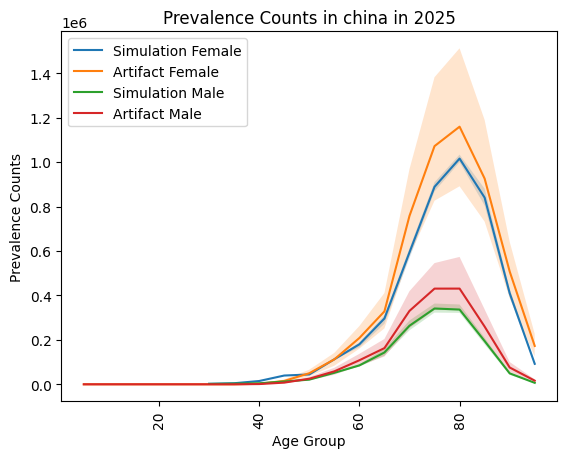

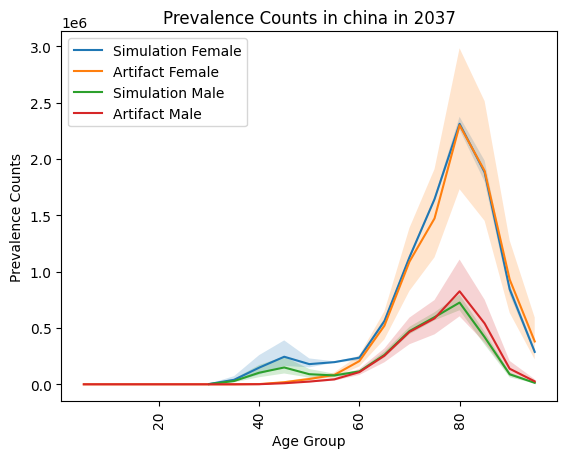

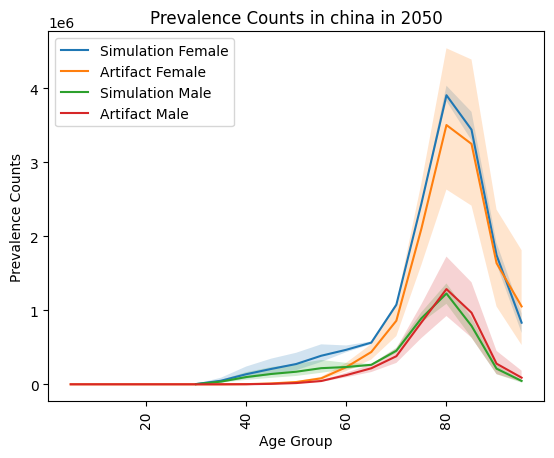

<Figure size 640x480 with 0 Axes>

In [65]:
for location in person_time_dementia.location.unique():
    for year in [2025,2037,2050]:
        for sex in person_time_dementia.sex.unique(): # [:1]:
            plot_data = person_time_dementia.loc[(person_time_dementia.location == location) & (person_time_dementia.event_year == year) & (person_time_dementia.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [66]:
cols = ['input_draw','event_year','location', 'scenario'] #, 'age_group']

# # FIXME: Don't reload person-time
# person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total.head()

,event_year,location,scenario,count,mean,std,min,2.5%,50%,97.5%,max
0,2022,china,baseline,3.0,2.035973e+06,3895.014161,2.033205e+06,2.033259e+06,2.034286e+06,2.040120e+06,2.040427e+06
1,2022,china,bbbm_testing,3.0,2.035973e+06,3895.014161,2.033205e+06,2.033259e+06,2.034286e+06,2.040120e+06,2.040427e+06
2,2022,china,bbbm_testing_and_treatment,3.0,2.035973e+06,3895.014161,2.033205e+06,2.033259e+06,2.034286e+06,2.040120e+06,2.040427e+06
3,2023,china,baseline,3.0,2.205847e+06,20089.807636,2.191830e+06,2.192081e+06,2.196849e+06,2.227263e+06,2.228863e+06
4,2023,china,bbbm_testing,3.0,2.205847e+06,20089.807636,2.191830e+06,2.192081e+06,2.196849e+06,2.227263e+06,2.228863e+06


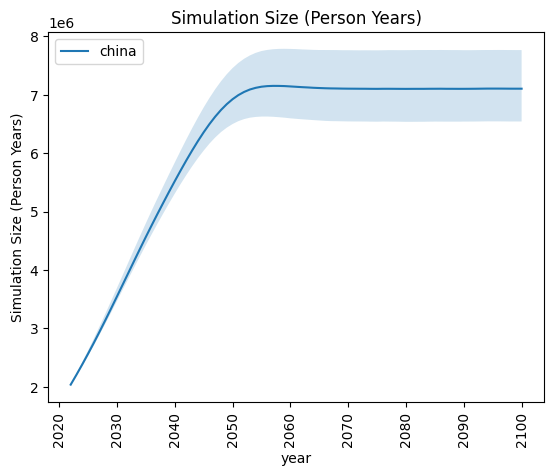

In [67]:
scenario = 'baseline'
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[
        (person_time_total.location == location) & (person_time_total.scenario == scenario)]
    plt.plot(plot_data.event_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()

# Decompose person-time by state

In [68]:
person_time

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,baseline,169,0.000000,china
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,baseline,323,0.000000,china
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,baseline,457,0.000000,china
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,bbbm_testing,169,0.000000,china
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,bbbm_testing,323,0.000000,china
...,...,...,...,...,...,...,...,...,...,...,...,...
959845,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing,323,176.394251,china
959846,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing,457,491.811088,china
959847,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing_and_treatment,169,218.250513,china
959848,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_severe_dementia_state,95_plus,2100,Male,no_effect_never_treated,bbbm_testing_and_treatment,323,48.832307,china


In [69]:
cols = ["input_draw", "event_year", "sub_entity", "location", "scenario"]  # , 'age_group']

person_time_total = person_time.groupby(cols, observed=True)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

,event_year,sub_entity,location,scenario,count,mean,std,min,2.5%,50%,97.5%,max
0,2022,alzheimers_blood_based_biomarker_state,china,baseline,3.0,988633.301392,9779.662607,980166.045175,980477.550445,986396.150582,998690.630527,999337.708419
1,2022,alzheimers_blood_based_biomarker_state,china,bbbm_testing,3.0,988633.301392,9779.662607,980166.045175,980477.550445,986396.150582,998690.630527,999337.708419
2,2022,alzheimers_blood_based_biomarker_state,china,bbbm_testing_and_treatment,3.0,988633.301392,9779.662607,980166.045175,980477.550445,986396.150582,998690.630527,999337.708419
3,2022,alzheimers_mild_cognitive_impairment_state,china,baseline,3.0,436379.610313,1499.946286,435173.585216,435210.209446,435906.069815,437951.520602,438059.175907
4,2022,alzheimers_mild_cognitive_impairment_state,china,bbbm_testing,3.0,436379.610313,1499.946286,435173.585216,435210.209446,435906.069815,437951.520602,438059.175907
...,...,...,...,...,...,...,...,...,...,...,...,...
1180,2100,alzheimers_moderate_dementia_state,china,bbbm_testing,3.0,829744.436231,74030.291710,752765.453799,756929.404517,836044.468172,897204.440794,900423.386721
1181,2100,alzheimers_moderate_dementia_state,china,bbbm_testing_and_treatment,3.0,800251.550080,70551.696654,727986.047912,731777.452977,803814.149213,865697.437919,868954.453114
1182,2100,alzheimers_severe_dementia_state,china,baseline,3.0,578455.711613,91088.244251,499627.745380,502524.597399,557564.785763,672144.112799,678174.603696
1183,2100,alzheimers_severe_dementia_state,china,bbbm_testing,3.0,578455.711613,91088.244251,499627.745380,502524.597399,557564.785763,672144.112799,678174.603696


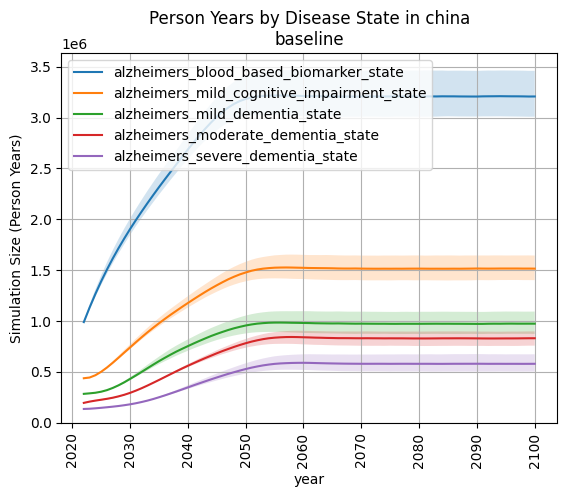

<Figure size 640x480 with 0 Axes>

In [73]:
scenario = 'baseline'
for location in person_time_total.location.unique():
    for sub_entity in person_time_total.sub_entity.unique():
        plot_data = person_time_total.query(
            "location == @location and sub_entity == @sub_entity and scenario == @scenario"
        )
        plt.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
        plt.fill_between(
            plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
        )
    plt.title(f"Person Years by Disease State in {location}\n{scenario}")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()
    plt.figure()

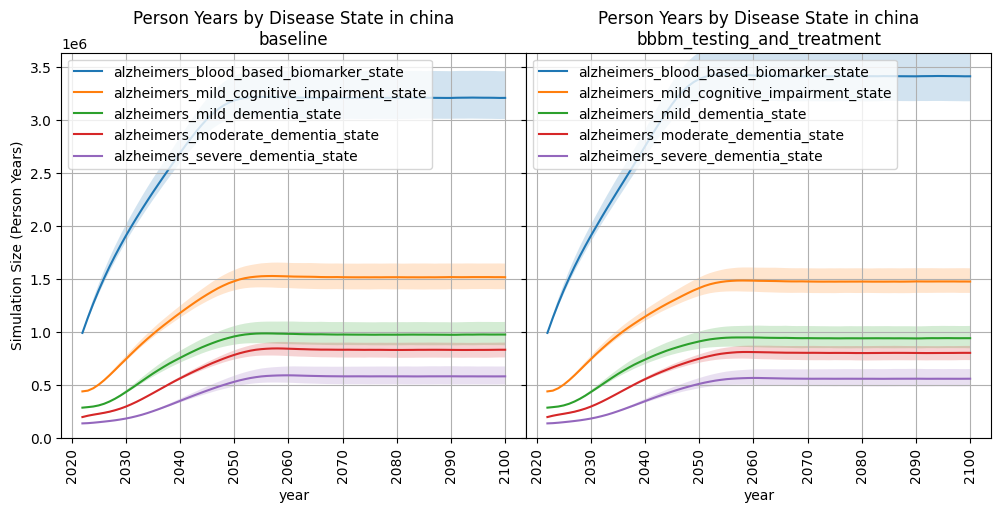

In [82]:
for location in person_time_total.location.unique():
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0)
    for scenario, ax in zip (['baseline', 'bbbm_testing_and_treatment'], axs):
        for sub_entity in person_time_total.sub_entity.unique():
            plot_data = person_time_total.query(
                "location == @location and sub_entity == @sub_entity and scenario == @scenario"
            )
            ax.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
            ax.fill_between(
                plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )
        ax.set_title(f"Person Years by Disease State in {location}\n{scenario}")
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("year")
        if scenario == 'baseline':
            ax.set_ylabel("Simulation Size (Person Years)")
        ax.legend()
        ax.axis(ymin=0)
        ax.grid()

plt.show()

In [71]:
!date

Wed Nov 19 12:57:27 PST 2025
